In [1]:
#### IMPORTS  ####
from pathlib import Path
from typing import Tuple, List
import matplotlib.pyplot as plt
from numba import njit
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import tqdm
import random
import datetime
import pathlib
import pytz
import glob
import re
from google.colab import drive
from torch.autograd import Variable
import seaborn as sns
import matplotlib.dates as mdates
!pip install torchinfo
from torchinfo import summary
!pip install captum
drive.mount('/content/drive', force_remount=True)

     |████████████████████████████████| 1.4 MB 4.1 MB/s 
Mounted at /content/drive


In [2]:
#### Definitions ####
PATH_ROOT = "drive/MyDrive/Efrat/" # Change only here the path
PATH_DATA  = PATH_ROOT + "Toy_Model/Data/synth_data_1.csv"
PATH_LABEL = PATH_ROOT + "Toy_Model/Data/output_data_1.csv"
PATH_MODEL = PATH_ROOT + "Toy_Model/lstm/"


def reshape_data(x: np.ndarray, y: np.ndarray, seq_length: int) -> Tuple[np.ndarray, np.ndarray]:
  """
  Reshape matrix data into sample shape for LSTM training.
  :param x: Matrix containing input features column wise and time steps row wise
  :param y: Matrix containing the output feature.
  :param seq_length: Length of look back days for one day of prediction 
  :return: Two np.ndarrays, the first of shape (samples, length of sequence,
    number of features), containing the input data for the LSTM. The second
    of shape (samples, 1) containing the expected output for each input
    sample.
  """
  num_samples, num_features = x.shape
  x_new = np.zeros((num_samples - seq_length + 1, seq_length, num_features))
  y_new = np.zeros((num_samples - seq_length + 1, 1))
  for i in range(0, x_new.shape[0]):
    x_new[i, :, :num_features] = x[i:i + seq_length, :]
    y_new[i, :] = y[i + seq_length - 1]
  return x_new, y_new

def load_input(input_file):
  data = pd.read_csv(input_file)
  precip = data['Rain(mm)'].to_numpy()
  PET = data['PET(mm)'].to_numpy()
  precip[np.isnan(precip)] = 0
  PET[np.isnan(PET)] = 0
  return precip, PET


In [3]:
class ToyData(Dataset):
  def __init__(self,  seq_length: int, perc_data: np.array, pet_data: np.array, dis_data: np.array, 
               period: str=None,
               min_values = None,max_values = None,
               mean_y = None,std_y = None,
               lead=0):
    self.seq_length = seq_length
    self.period = period
    self.perc_data = perc_data
    self.pet_data = pet_data
    self.dis_data = dis_data
    self.min_values = min_values
    self.max_values = max_values
    self.mean_y = mean_y
    self.std_y = std_y
    self.lead = lead

    # load data into memory
    self.x , self.y= self._load_data()
    # store number of samples as class attribute
    self.num_samples = self.x.shape[0]
    # store number of features as class attribute
    self.num_features = self.x.shape[2]

  def __len__(self):
    return self.num_samples

  def __getitem__(self, idx: int):
    return self.x[idx], self.y[idx]

  def _load_data(self):
    """Load input and output data from text files."""
    x = np.array([self.perc_data, self.pet_data]).T
    y = np.array(self.dis_data)

    if self.period == 'train':
      # Normalize percipitation via min/max only on events 
      self.min_values  = x.min(axis=0)
      self.max_values = x.max(axis=0)
      # Normalize discharge via mean/std  only on events
      self.mean_y = y.mean()
      self.std_y = y.std()
      y -= self.mean_y
      y /= self.std_y
    
    time_span, num_features = x.shape
    for i in range(num_features):
      x[:,i]  -= self.min_values[i]
      x[:,i] /= (self.max_values[i] - self.min_values[i])

    
    # normalize data, reshape for LSTM training and remove invalid samples
    x_new, y_new = reshape_data(x[:-self.lead, :], y[self.lead:], self.seq_length)
    print("Data set for {0}".format(self.period))
    print("Number of features should be: num_features".format(num_features))
    print("Number of sample should be: (time_span - sequence_len + 1 -lead)= {0}".format((time_span - self.seq_length + 1 - self.lead)))
    print("Data size for LSTM should be: (num_samples, sequence_len, num_features) = {0}".format(x_new.shape))
    
      # convert arrays to torch tensors
    x = torch.from_numpy(x_new.astype(np.float32))
    y = torch.from_numpy(y_new.astype(np.float32))
    return x, y

  def local_rescale_out(self, feature: np.ndarray):
    return feature * self.std_y + self.mean_y

  def get_means(self):
    return self.means

  def get_stds(self):
    return self.stds

  def get_mean_y(self):
    return self.mean_y

  def get_std_y(self):
    return self.std_y
    
  def get_num_features(self):
    return self.num_features


In [4]:
class Model(nn.Module):
    """Implementation of a single layer LSTM network"""
    
    def __init__(self, input_size: int , hidden_size: int, dropout_rate: float=0.0, num_layers: int=1, data_sets = None):
        """Initialize model
        
        :param hidden_size: Number of hidden units/LSTM cells
        :param dropout_rate: Dropout rate of the last fully connected
            layer. Default 0.0
        """
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate
        
        # create required layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=self.hidden_size, 
                            num_layers=num_layers, bias=True, batch_first=True)
        self.dropout = nn.Dropout(p=self.dropout_rate)
        self.fc = nn.Linear(in_features=self.hidden_size, out_features=1)
        self.data_sets = data_sets
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the Network.
        
        :param x: Tensor of shape [batch size, seq length, num features]
            containing the input data for the LSTM network.
        
        :return: Tensor containing the network predictions
        """
        output, (h_n, c_n) = self.lstm(x)
        
        # perform prediction only at the end of the input sequence
        pred = self.fc(self.dropout(h_n[-1,:,:]))
        return pred

def train_epoch(model, optimizer, loader, loss_func, epoch):
    """Train model for a single epoch.

    :param model: A torch.nn.Module implementing the LSTM model
    :param optimizer: One of PyTorchs optimizer classes.
    :param loader: A PyTorch DataLoader, providing the trainings
        data in mini batches.
    :param loss_func: The loss function to minimize.
    :param epoch: The current epoch (int) used for the progress bar
    """
    # set model to train mode (important for dropout)
    model.train()
    pbar = tqdm.notebook.tqdm(loader)
    pbar.set_description(f"Epoch {epoch}")
    # request mini-batch of data from the loader
    for xs, ys in pbar:
        # delete previously stored gradients from the model
        optimizer.zero_grad()
        # push data to GPU (if available)
        xs, ys = xs.to(device), ys.to(device)
        # get model predictions
        y_hat = model(xs)
        # calculate loss
        loss = loss_func(y_hat, ys)
        # calculate gradients
        loss.backward()
        # update the weights
        optimizer.step()
        # write current loss in the progress bar
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        
def eval_model(model, loader) -> Tuple[torch.Tensor, torch.Tensor]:
    """Evaluate the model.

    :param model: A torch.nn.Module implementing the LSTM model
    :param loader: A PyTorch DataLoader, providing the data.
    
    :return: Two torch Tensors, containing the observations and 
        model predictions
    """
    # set model to eval mode (important for dropout)
    model.eval()
    obs = []
    preds = []
    # in inference mode, we don't need to store intermediate steps for
    # backprob
    with torch.no_grad():
        # request mini-batch of data from the loader
        for xs, ys in loader:
            # push data to GPU (if available)
            xs = xs.to(device)
            # get model predictions
            y_hat = model(xs)
            obs.append(ys)
            preds.append(y_hat)
            
    return torch.cat(obs), torch.cat(preds)
        
def calc_nse(obs: np.array, sim: np.array) -> float:
    """Calculate Nash-Sutcliff-Efficiency.

    :param obs: Array containing the observations
    :param sim: Array containing the simulations
    :return: NSE value.
    """
    # only consider time steps, where observations are available
    sim = np.delete(sim, np.argwhere(obs < 0), axis=0)
    obs = np.delete(obs, np.argwhere(obs < 0), axis=0)

    # check for NaNs in observations
    sim = np.delete(sim, np.argwhere(np.isnan(obs)), axis=0)
    obs = np.delete(obs, np.argwhere(np.isnan(obs)), axis=0)

    denominator = np.sum((obs - np.mean(obs)) ** 2)
    numerator = np.sum((sim - obs) ** 2)
    nse_val = 1 - numerator / denominator

    return nse_val
  
def calc_bias(obs: np.array, sim: np.array) -> float:
    """ Calculate bias

    :param obs: Array containing the observations
    :param sim: Array containing the simulations
    :return: NSE value.
    """
    bias_95 = np.percentile(sim, 95) - np.percentile(obs, 95)
    bias_5 = np.percentile(sim, 5) - np.percentile(obs, 5)
    mean_sim = np.mean(sim)
    mean_obs = np.mean(obs)

    return bias_95, bias_5, (mean_sim-mean_obs)/mean_sim*100

In [5]:
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
#print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

#################################
###### Meta parameters ##########
#################################
hidden_size = 10 # Number of LSTM cells
dropout_rate = 0.01 # Dropout rate of the final fully connected Layer [0.0, 1.0]
learning_rate = 1e-3 # Learning rate used to update the weights
sequence_length = 40 # Length of the meteorological record provided to the network
num_layers = 1 # Number of LSTM cells
lead = 1

### Load Data ###
perc_data, pet_data = load_input(PATH_DATA)
dis_data = pd.read_csv(PATH_LABEL, header=None, index_col=None).to_numpy().flatten()

# Train data. 
data_size = len(dis_data)
idx_test = int(len(dis_data)*0.8) 
ds_train = ToyData(seq_length=sequence_length, perc_data=perc_data[:idx_test], pet_data=pet_data[:idx_test], dis_data=dis_data[:idx_test], period="train", lead=lead)
tr_loader = DataLoader(ds_train, batch_size=64, shuffle=True)

# Test data. We use the feature means/stds of the training period for normalization
ds_test = ToyData(seq_length=sequence_length, perc_data=perc_data[idx_test:], pet_data=pet_data[idx_test:], dis_data=dis_data[idx_test:], period="eval", 
                  min_values = ds_train.min_values, max_values = ds_train.max_values, 
                  mean_y=ds_train.mean_y, std_y=ds_train.std_y, lead=lead)
test_loader = DataLoader(ds_test, batch_size=2048, shuffle=False)



Data set for train
Number of features should be: num_features
Number of sample should be: (time_span - sequence_len + 1 -lead)= 302380
Data size for LSTM should be: (num_samples, sequence_len, num_features) = (302380, 40, 2)
Data set for eval
Number of features should be: num_features
Number of sample should be: (time_span - sequence_len + 1 -lead)= 75566
Data size for LSTM should be: (num_samples, sequence_len, num_features) = (75566, 40, 2)


In [8]:
#########################
# Model, Optimizer, Loss#
#########################

# Here we create our model, feel free
path_to_ckpt = None
path_to_ckpt = PATH_MODEL +  "2021_12_01-13-06-53/epoch_32_nse_0.693.ckpt" 
if path_to_ckpt:
  model = torch.load(path_to_ckpt).to(device)
else: 
  model = Model(input_size=ds_train.num_features, num_layers=num_layers, hidden_size=hidden_size, dropout_rate=dropout_rate, data_sets={'X': PATH_DATA, 'Y': PATH_LABEL}).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.MSELoss()
summary(model)

Layer (type:depth-idx)                   Param #
Model                                    --
├─LSTM: 1-1                              560
├─Dropout: 1-2                           --
├─Linear: 1-3                            11
Total params: 571
Trainable params: 571
Non-trainable params: 0

In [ ]:
n_epochs = 50 # Number of training epochs
# Creating the checkpoint folders
datetime_israel = datetime.datetime.now(pytz.timezone('Israel'))
path_train_ckpt = PATH_MODEL + datetime_israel.strftime("%Y_%m_%d-%H-%M-%S/") 
pathlib.Path(path_train_ckpt).mkdir(parents=True, exist_ok=True)

eval_list = [] 
for i in range(n_epochs):
    train_epoch(model, optimizer, tr_loader, loss_func, i+1)
    obs, preds = eval_model(model, test_loader)
    preds = ds_test.local_rescale_out(preds.cpu().numpy())
    nse = calc_nse(obs.numpy(), preds)
    tqdm.tqdm.write(f"Test NSE: {nse:.3f}")
    model_name = "epoch_{:d}_nse_{:.3f}.ckpt".format(i+1, nse)
    torch.save(model, path_train_ckpt + model_name)
    eval_list.append(preds)

  0%|          | 0/4725 [00:00<?, ?it/s]

Test NSE: 0.690


  0%|          | 0/4725 [00:00<?, ?it/s]

Test NSE: 0.662


  0%|          | 0/4725 [00:00<?, ?it/s]

Test NSE: 0.685


  0%|          | 0/4725 [00:00<?, ?it/s]

Test NSE: 0.660


  0%|          | 0/4725 [00:00<?, ?it/s]

Test NSE: 0.670


  0%|          | 0/4725 [00:00<?, ?it/s]

Test NSE: 0.697


  0%|          | 0/4725 [00:00<?, ?it/s]

Test NSE: 0.678


  0%|          | 0/4725 [00:00<?, ?it/s]

Test NSE: 0.687


  0%|          | 0/4725 [00:00<?, ?it/s]

Test NSE: 0.701


  0%|          | 0/4725 [00:00<?, ?it/s]

Test NSE: 0.702


  0%|          | 0/4725 [00:00<?, ?it/s]

Test NSE: 0.658


  0%|          | 0/4725 [00:00<?, ?it/s]

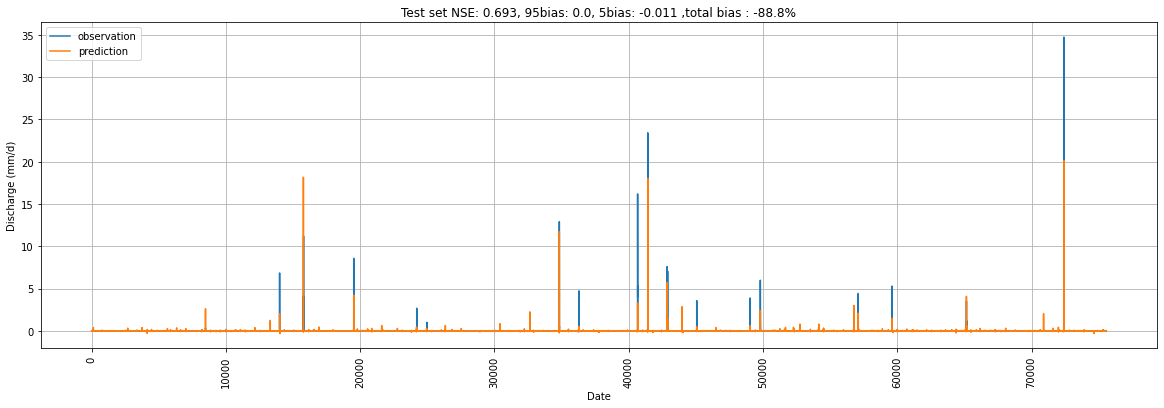

In [9]:
# Evaluate on test set
# Validation data. We use the feature means/stds of the training period for normalization
ds_val = ds_test
val_loader = DataLoader(ds_val, batch_size=2048, shuffle=False)
obs, preds = eval_model(model, val_loader)
preds = ds_val.local_rescale_out(preds.cpu().numpy())
#preds = preds.cpu().numpy()
obs = obs.numpy()
nse = calc_nse(obs, preds)
pb95, pb5, total_b =  calc_bias(obs, preds)
# Plot results
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(obs, label="observation")
ax.plot(preds, label="prediction")
ax.legend()
ax.set_title(f"Test set NSE: {nse:.3f}, 95bias: {pb95:.1f}, 5bias: {pb5:.3f} ,total bias : {total_b: .1f}%")
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel("Date")
ax.grid('on')
_ = ax.set_ylabel("Discharge (mm/d)")

In [ ]:
# Install package
!pip install captum
from captum.attr import IntegratedGradients
from captum.attr import DeepLiftShap

In [ ]:
p_thersh = (np.percentile(dis_data,99.9))
idx_low = np.where( np.bitwise_and(ds_test.y > 0, ds_test.y < p_thersh))[0]
idx_high = np.where(ds_test.y >= p_thersh)[0]

In [ ]:
# set model to eval mode (important for dropout)
model.eval()
model.cpu()
ig =  IntegratedGradients(model, multiply_by_inputs=True)
input = Variable(ds_val.x[idx_low, : ])
basline = torch.zeros(input.shape)
att_low = ig.attribute(input, basline, n_steps=100).numpy().mean(axis=0)

input = Variable(ds_val.x[idx_high, : ])
basline = torch.zeros(input.shape)
att_high = ig.attribute(input, basline, n_steps=100).numpy().mean(axis=0)

#_ = model.cuda()

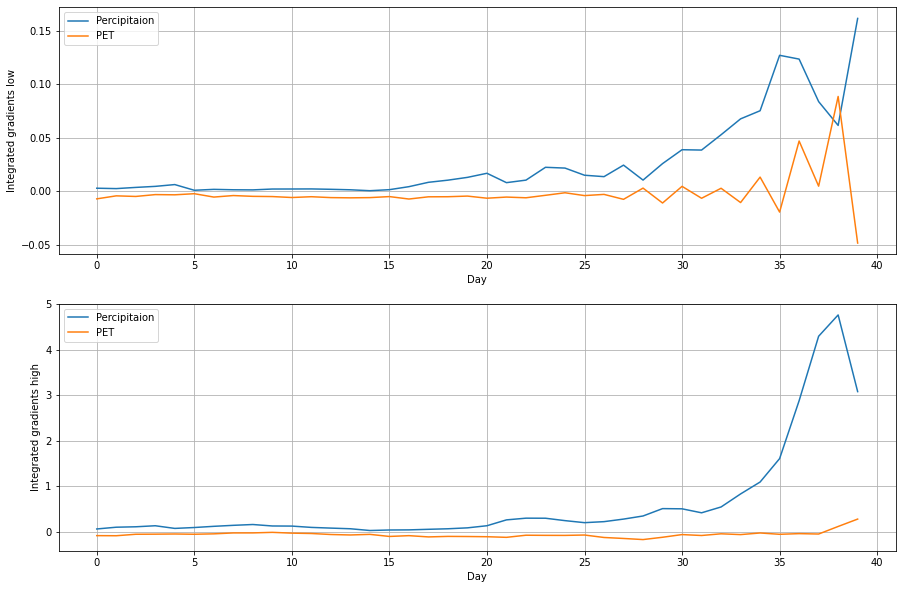

In [ ]:
# plot 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

ax1.plot(att_low)
ax1.set_xlabel("Day")
ax1.set_ylabel("Integrated gradients low")
ax1.grid('on')
ax1.legend(['Percipitaion', 'PET'])

ax2.plot(att_high)
ax2.set_xlabel("Day")
ax2.set_ylabel("Integrated gradients high")
ax2.grid('on')
ax2.legend(['Percipitaion', 'PET'])

In [ ]:
# set model to eval mode (important for dropout)
model.eval()
model.cpu()
dl = DeepLiftShap(model)


input = Variable(ds_val.x[idx_low, : ])
basline = torch.zeros(input.shape)
att_low = dl.attribute(input, basline).detach().numpy().mean(axis=0)

input = Variable(ds_val.x[idx_high, : ])
basline = torch.zeros(input.shape)
att_high = dl.attribute(input, basline).detach().numpy().mean(axis=0)


/usr/local/lib/python3.7/dist-packages/captum/attr/_core/deep_lift.py:323: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""


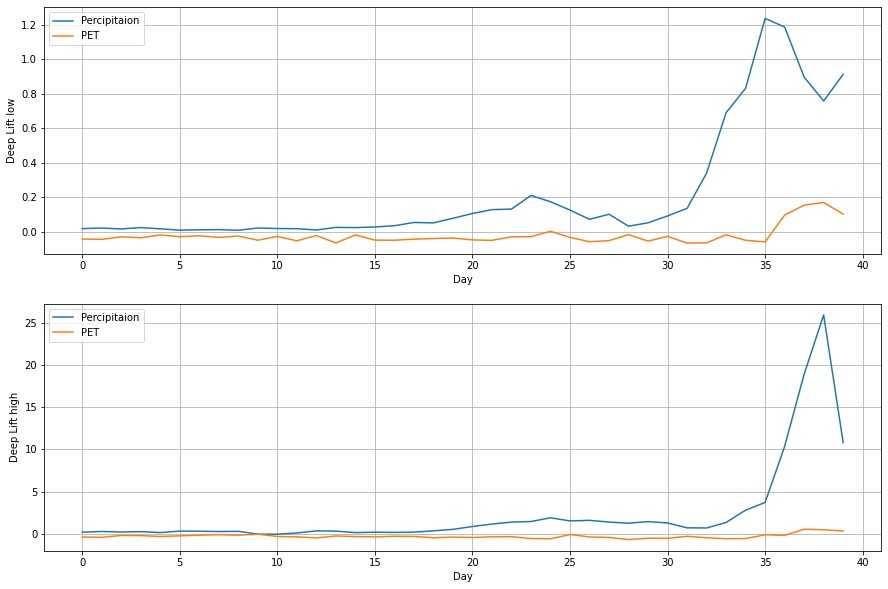

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

ax1.plot(att_low)
ax1.set_xlabel("Day")
ax1.set_ylabel("Deep Lift low")
ax1.grid('on')
ax1.legend(['Percipitaion', 'PET'])

ax2.plot(att_high)
ax2.set_xlabel("Day")
ax2.set_ylabel("Deep Lift high")
ax2.grid('on')
ax2.legend(['Percipitaion', 'PET'])